In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"/kaggle/input/datasets/mirichoi0218/insurance/insurance.csv")

# Objective

Which lifestyle and demographic factors drive medical insurance costs?

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.shape

(1338, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe().round(1)

,age,bmi,children,charges
count,1338.0,1338.0,1338.0,1338.0
mean,39.2,30.7,1.1,13270.4
std,14.0,6.1,1.2,12110.0
min,18.0,16.0,0.0,1121.9
25%,27.0,26.3,0.0,4740.3
50%,39.0,30.4,1.0,9382.0
75%,51.0,34.7,2.0,16639.9
max,64.0,53.1,5.0,63770.4


In [7]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [8]:
df = df.drop_duplicates()

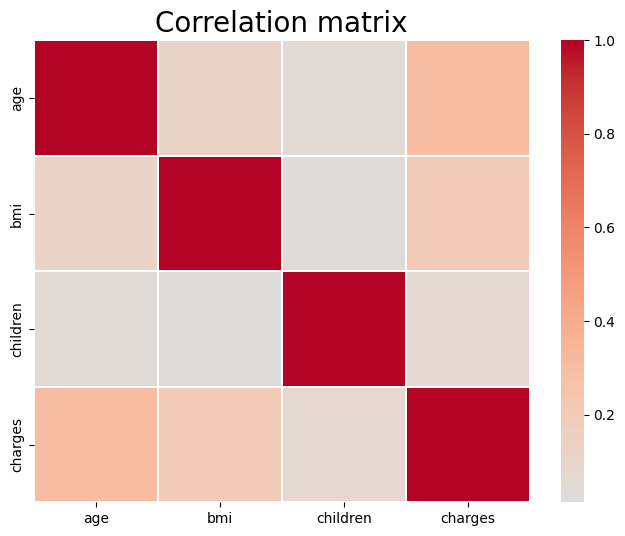

In [9]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.2
)

plt.title("Correlation matrix", fontsize=20)
plt.show()

# Target = charges

<Axes: >

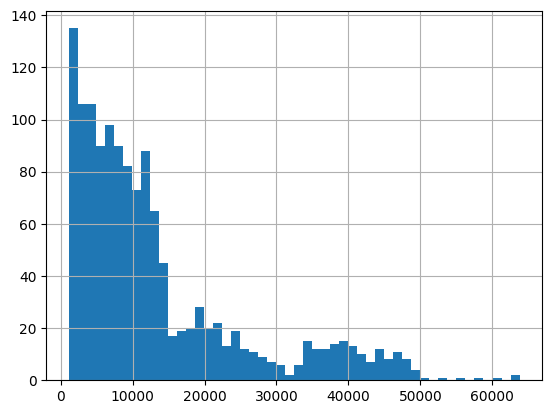

In [10]:
df['charges'].hist(bins=50)

In [11]:
df['charges'].skew().round(2)

np.float64(1.52)

In [12]:
df['charges'].describe().round(2)

count     1337.00
mean     13279.12
std      12110.36
min       1121.87
25%       4746.34
50%       9386.16
75%      16657.72
max      63770.43
Name: charges, dtype: float64

- mean is much higher than the median : a smaller number of people have extremely high medical costs
- right skew
- 


Age bands

In [13]:
df['age_band'] = pd.cut(df['age'],bins=[18, 30, 40, 50, 60, df['age'].max()],labels=['young_adult','adult','mid','pre_retirement','retirement'],right=False)

In [14]:
age_check = df.groupby('age_band').agg(
    mean=('charges', 'mean'),
    median=('charges', 'median'),
    std=('charges', 'std'),
    count=('charges', 'size')
).sort_values(by='median', ascending=False)

age_check.round(2)

/tmp/ipykernel_17/899547078.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_check = df.groupby('age_band').agg(


,mean,median,std,count
age_band,,,,
retirement,20763.18,13903.90,12372.98,92
pre_retirement,16495.23,11729.68,10976.95,271
mid,14399.20,8606.22,11639.98,279
adult,11738.78,6082.40,11789.07,257
young_adult,9200.62,3220.37,11473.33,416


- charges increase steadily with age
- medical expenses are highly uneven — especially in older groups
- standard deviation doesn't vary a lot, the costs vary a lot

In [15]:
smoker_check = df.groupby('smoker').agg(
    mean=('charges', 'mean'),
    median=('charges', 'median'),
    std=('charges', 'std'),
    count=('charges', 'size')
).sort_values(by='median', ascending=False)

smoker_check.round(2)

,mean,median,std,count
smoker,,,,
yes,32050.23,34456.35,11541.55,274
no,8440.66,7345.73,5992.97,1063


- smokers cost roughly 3–4× more than non-smokers
- lifestyle behavior (smoking) is a dominant driver of insurance costs
- median > mean - costs among smokers are consistently high, not just driven by a few extreme outliers
- standard deviation - costs vary a lot among smokers

In [16]:
df.groupby(['age_band','smoker'])['charges'].mean().unstack().round(1)

/tmp/ipykernel_17/2570673692.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['age_band','smoker'])['charges'].mean().unstack().round(1)


smoker,no,yes
age_band,,
young_adult,4427.0,27518.0
adult,6337.4,30271.2
mid,9183.3,32654.7
pre_retirement,12749.3,37508.8
retirement,15113.4,41102.4


Age and smoking don’t replace each other — they stack

# Linear Regression


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [18]:
y = df['charges']

X = df.drop(columns='charges')

In [19]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [21]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
coefficients = pd.Series(model.coef_, index=X_encoded.columns)
coefficients.sort_values(ascending=False).round(2)

smoker_yes                 23078.46
age_band_retirement          992.82
children                     751.45
bmi                          313.68
age                          243.05
sex_male                    -107.50
age_band_pre_retirement     -220.55
region_northwest            -399.87
region_southwest            -610.31
region_southeast            -786.94
age_band_mid               -1628.37
age_band_adult             -2081.27
dtype: float64

- smoker_yes ≈ +23,078 --> holding everything else constant, smokers are predicted to cost about 23k more than non-smokers
- bmi ≈ +313.68 --> for each +1 BMI unit, insurance charges increase by about $313, assuming other factors stay the same
- region_southeast ≈ -786, region_southwest ≈ -610 --> relative to the baseline region (probably northeast), these regions have slightly lower average costs

In [23]:
from sklearn.metrics import mean_absolute_error

# R²
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

# Predictions
y_pred = model.predict(X_test)

# MAE
mae = mean_absolute_error(y_test, y_pred)

print("R2 Train:", r2_train)
print("R2 Test:", r2_test)
print("MAE:", mae)

R2 Train: 0.7362696140065654
R2 Test: 0.802957810569846
MAE: 4265.904035187442


On average, the model’s cost estimate differs from actual charges by roughly four thousand dollars

# Project Conclusion — Medical Insurance Charges Analysis
🎯 Objective

The goal of this project was to understand which demographic and lifestyle factors most strongly influence individual medical insurance charges. Rather than focusing on complex modeling techniques, the analysis emphasized exploratory data analysis (EDA), statistical reasoning, and interpretable linear regression.

🔎 Key Exploratory Insights

Initial analysis revealed that insurance charges are heavily right-skewed, indicating that a small subset of individuals accounts for disproportionately high medical expenses.

Behavioral segmentation uncovered a strong structural pattern:

Smoking status emerged as the most influential driver of insurance costs.

Charges increased steadily across age bands, but smoking shifted the entire cost distribution upward.

BMI showed a gradual positive relationship with charges, suggesting a compounding lifestyle effect rather than a sudden cost jump.

When combining age and smoking, smokers consistently exhibited dramatically higher costs across all life stages, highlighting the interaction between demographic and behavioral risk factors.

📊 Modeling Approach

A linear regression model was developed to quantify how these variables contribute to insurance pricing.

Key modeling decisions:

Categorical variables were encoded using one-hot encoding.

The model focused on interpretability rather than predictive complexity.

Performance was evaluated using R² and Mean Absolute Error (MAE).

📈 Model Performance

R² (Test): ~0.80
The model explains approximately 80% of the variation in insurance charges, indicating strong explanatory power for a baseline linear model.

MAE: ~4,266
On average, predictions differ from actual charges by about $4k, which is reasonable given the wide range of expenses.

These results suggest that a small set of demographic and lifestyle variables captures much of the pricing structure.

💡 Key Analytical Findings

Smoking status introduces a substantial cost increase (~$23k on average), making it the dominant predictor.

Age contributes a steady incremental rise in expected charges.

BMI has a consistent positive effect, reflecting gradual health risk accumulation.

Regional and gender effects appear comparatively modest.

Overall, the analysis highlights how behavioral factors can outweigh purely demographic attributes in determining healthcare expenses.

🛠️ Tools Used

Python · Pandas · Matplotlib · Scikit-learn